In [ ]:
# Checkout www.pygimli.org for more examples


# 2D ERT modelling and inversion


Note - edited somewhat from original pyGimli example to compare with some Acacia survey data (2024-03-07-OPTHOF)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

## Geometry definition
Create geometry definition for the modelling domain. ``worldMarker=True``
indicates the default boundary conditions for the ERT



In [21]:
world = mt.createWorld(start=[0, 0], end=[100, -50], layers=[-1, -10],
                       worldMarker=True)

Create some heterogeneous circular anomaly



In [5]:
block = mt.createCircle(pos=[-5, -3.], radius=[4, 1], marker=4,
                        boundaryMarker=10, area=0.1)

In [6]:
poly = mt.createPolygon([(1,-4), (2,-1.5), (4,-2), (5,-2),
                         (8,-3), (5,-3.5), (3,-4.5)], isClosed=True,
                         addNodes=3, interpolate='spline', marker=5)

Merge geometry definition into a Piecewise Linear Complex (PLC)



In [22]:
geom = world #+ block + poly

Optional: show the geometry



(<Axes: >, None)

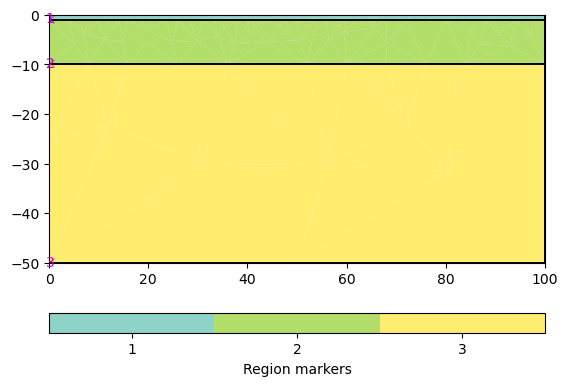

In [31]:
pg.show(geom)

## Synthetic data generation
Create a Dipole Dipole ('dd') measuring scheme with 21 electrodes.



In [32]:
scheme = ert.createData(elecs=np.linspace(start=35, stop=65, num=21),
                           schemeName='dd')
print(scheme.sensors())

Unknown scheme name: dad
-----------------------
Valid names or prefixes
-----------------------
unknown :  uk
Wenner Alpha (C-P-P-C) :  wa
Wenner Beta(C-C-P-P) :  wb
Dipole Dipole (CC-PP) :  dd
Schlumberger(C-PP-C) :  slm
Pole Pole (C-P) :  pp
Pole Dipole (C-PP) :  pd
Half Wenner (C-P-P) :  hw
MultipleGradient(C--P-P--C) :  gr
A_M :  uk
AB_MN :  uk
AB_M :  uk
AB_N :  uk


Exception: ('No scheme known for name: ', 'dad')

Put all electrode (aka sensors) positions into the PLC to enforce mesh
refinement. Due to experience, its convenient to add further refinement
nodes in a distance of 10% of electrode spacing to achieve sufficient
numerical accuracy.



(-15.0, 0.0)

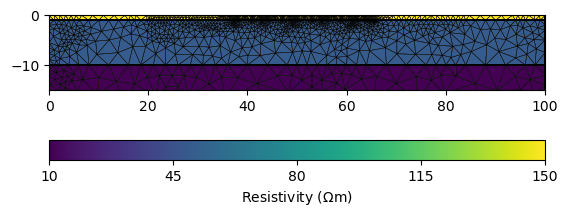

In [25]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=34)

# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [[1, 150.],
          [2, 50.],
          [3, 10.],]
          #[4, 150.],
          #[5, 25]]

# Take a look at the mesh and the resistivity distribution
ax, _ = pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)
ax.set_ylim(-15,0)
#ax.set_xlim(0,100)

Perform the modelling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 1% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes.



In [26]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

30/05/24 - 12:04:07 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000239119987339 : 0.011077614194541069
30/05/24 - 12:04:07 - pyGIMLi - INFO - 0.13217954192142778 846.3989662042237
30/05/24 - 12:04:07 - pyGIMLi - INFO - Simulated data Data: Sensors: 21 data: 171, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
30/05/24 - 12:04:07 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
30/05/24 - 12:04:07 - pyGIMLi - INFO - Simulated rhoa (min/max) 29.558434153447774 119.9418760635372
30/05/24 - 12:04:07 - pyGIMLi - INFO - Selected data noise %(min/max) 1.000023911998734 1.1077614194541068


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


Optional: you can filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



30/05/24 - 12:05:10 - pyGIMLi - INFO - Filtered rhoa (min/max) 29.558434153447774 119.9418760635372


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x241bce06cb0>)

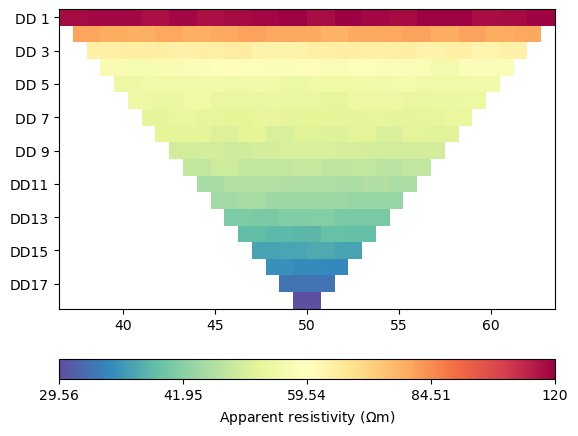

In [27]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('simple.dat')

# You can take a look at the data
ert.show(data)

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [28]:
mgr = ert.ERTManager('simple.dat')

Run the inversion with the preset data. The Inversion mesh will be created
with default settings.



In [29]:
inv = mgr.invert(lam=20, verbose=True)
np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

30/05/24 - 12:06:27 - pyGIMLi - INFO - Found 2 regions.
30/05/24 - 12:06:27 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
30/05/24 - 12:06:27 - pyGIMLi - INFO - Found 2 regions.
30/05/24 - 12:06:27 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
30/05/24 - 12:06:27 - pyGIMLi - INFO - Creating forward mesh from region infos.
30/05/24 - 12:06:27 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
30/05/24 - 12:06:27 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 987 Cells: 1824 Boundaries: 1442
30/05/24 - 12:06:27 - pyGIMLi - INFO - Use median(data values)=53.5523442763776
30/05/24 - 12:06:27 - pyGIMLi - INFO - Created startmodel from forward operator: 287, min/max=53.552344/53.552344
30/05/24 - 12:06:27 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000241BA43FA10>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000241BC681990>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000002416B5E8F90>
min/max (data): 29.56/120
min/max (error): 1%/1.11%
min/max (start model): 53.55/53.55
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1034.58
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   59.17 (dPhi = 93.81%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    2.61 (dPhi = 91.42%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    0.66 (dPhi = 33.43%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.66)     

Let the ERTManger show you the model of the last successful run and how it
fits the data. Shows data, model response, and model.



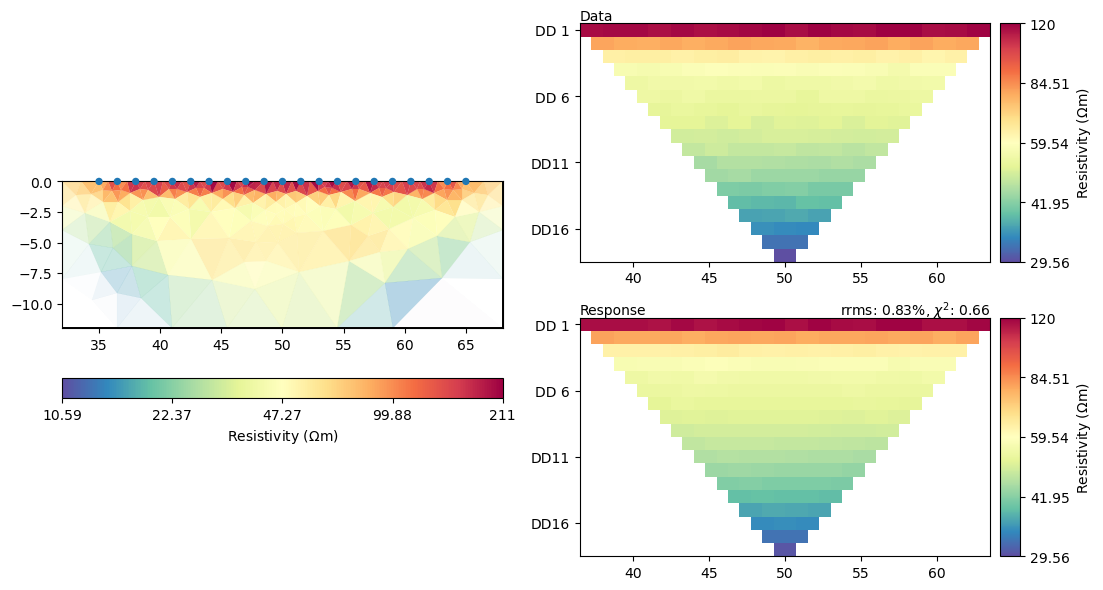

In [30]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later

You can also provide your own mesh (e.g., a structured grid if you like them)
Note, that x and y coordinates needs to be in ascending order to ensure that
all the cells in the grid have the correct orientation, i.e., all cells need
to be numbered counter-clockwise and the boundary normal directions need to
point outside.



(<Axes: >, <matplotlib.colorbar.Colorbar at 0x158beaa8a00>)

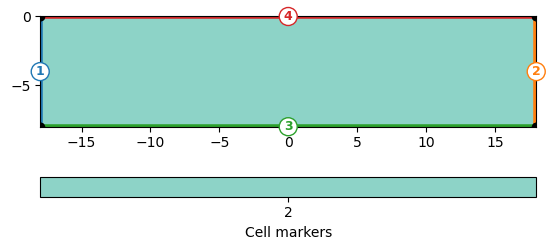

In [16]:
inversionDomain = pg.createGrid(x=np.linspace(start=-18, stop=18, num=33),
                                y=-pg.cat([0], pg.utils.grange(0.5, 8, n=5))[::-1],
                                marker=2)
pg.show(inversionDomain, markers=True)

## Inversion with custom mesh
The inversion domain for ERT problems needs a boundary that represents the
far regions in the subsurface of the halfspace.
Give a cell marker lower than the marker for the inversion region, the lowest
cell marker in the mesh will be the inversion boundary region by default.



(<Axes: >, <matplotlib.colorbar.Colorbar at 0x158bed8bee0>)

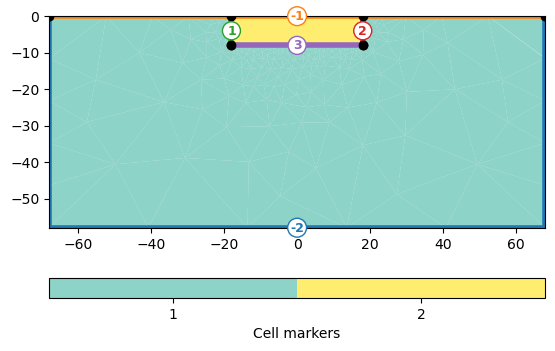

In [18]:
grid = pg.meshtools.appendTriangleBoundary(inversionDomain, marker=1,
                                           xbound=50, ybound=50)
pg.show(grid, markers=True)

The Inversion can be called with data and mesh as argument as well



In [19]:
model = mgr.invert(data, mesh=grid, lam=20, verbose=True)

06/05/24 - 14:03:53 - pyGIMLi - INFO - Found 2 regions.
06/05/24 - 14:03:53 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
06/05/24 - 14:03:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
06/05/24 - 14:03:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
06/05/24 - 14:03:53 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1462 Cells: 2164 Boundaries: 1842
06/05/24 - 14:03:53 - pyGIMLi - INFO - Use median(data values)=67.9439561191829
06/05/24 - 14:03:53 - pyGIMLi - INFO - Created startmodel from forward operator: 160, min/max=67.943956/67.943956
06/05/24 - 14:03:53 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000158BDD25850>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000158B604AF20>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000158B6AE0FE0>
min/max (data): 42.79/104
min/max (error): 1%/1.06%
min/max (start model): 67.94/67.94
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  468.39
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   77.93 (dPhi = 83.06%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    5.37 (dPhi = 91.06%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.02 (dPhi = 44.59%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.51 (dPhi = 11.05%) lam: 20.0
-----------

## Visualization
You can of course get access to mesh and model and plot them for your own.
Note that the cells of the parametric domain of your mesh might be in
a different order than the values in the model array if regions are used.
The manager can help to permutate them into the right order.



06/05/24 - 15:52:45 - pyGIMLi - INFO - Inversion stopped with chi² = 1.42


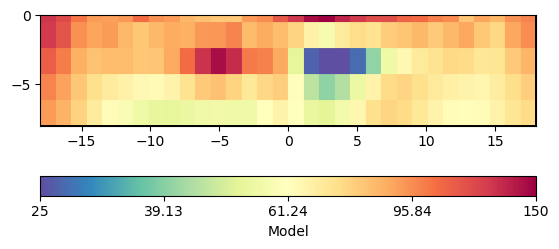

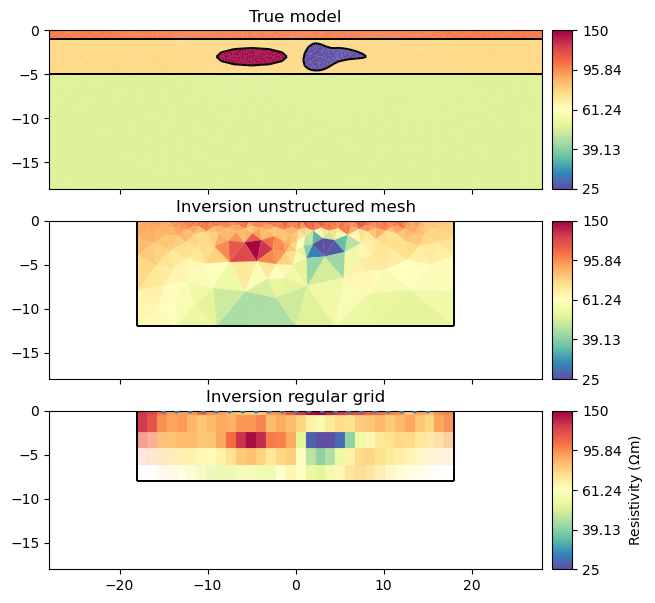

In [23]:
modelPD = mgr.paraModel(model)  # do the mapping
pg.show(mgr.paraDomain, modelPD, label='Model', cMap='Spectral_r',
        logScale=True, cMin=25, cMax=150)

pg.info('Inversion stopped with chi² = {0:.3}'.format(mgr.fw.chi2()))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,7))

pg.show(mesh, rhomap, ax=ax1, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", cMin=25, cMax=150)
pg.show(meshPD, inv, ax=ax2, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", cMin=25, cMax=150)
mgr.showResult(ax=ax3, cMin=25, cMax=150, orientation="vertical")

labels = ["True model", "Inversion unstructured mesh", "Inversion regular grid"]
for ax, label in zip([ax1, ax2, ax3], labels):
    ax.set_xlim(mgr.paraDomain.xmin()-10, mgr.paraDomain.xmax()+10)
    ax.set_ylim(mgr.paraDomain.ymin()-10, mgr.paraDomain.ymax())
    ax.set_title(label)